##### Install libs needed

In [ ]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install torchtext
!pip3 install pandas
!pip3 install nltk
!pip3 install -U scikit-learn scipy matplotlib
!pip3 install spacy
!pip3 install transformers datasets evaluate
!pip3 install --upgrade accelerate
!pip3 install textaugment
!pip3 install -U tqdm

##### Import libs 

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
# Hugging Face Dataset
from datasets import Dataset
# Model performance evaluation
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, TextClassificationPipeline
import evaluate
import string
from tqdm import tqdm

In [ ]:
# This part is when you are using GPU of Nvidia.
device = torch.device("cpu")
# If a GPU is available, set the device to GPU.
if torch.cuda.is_available:
  device = torch.device("cuda")
  print("GPU is available")
else:
  print("GPU is not available, CPU used")

GPU is available


In [ ]:
# Download the stopwords from nltk 
nltk.download('stopwords')
ntst = stopwords.words('english')
print(ntst)
print(len(ntst))

# Download the stopwords from spacy
from spacy.lang.en.stop_words import STOP_WORDS
print(STOP_WORDS)
print(len(STOP_WORDS))

# Merge the two stopwords above to one set
stwords = set(ntst).union(STOP_WORDS)
print(stwords)
print(len(stwords))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
##### Preprocessing the data when reading the data from csv file #####
# Delete the stopwords
def delete_stopwords(text):
  text = str(text)
  tx_arr = text.split()
  [w for w in tx_arr if w not in stwords]
  return ' '.join( [w for w in tx_arr if w not in stwords])

def clean_str(string):
    string = str(string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

# Replace the empty text with np.NaN so that we can apply 'dropna' to the all the rows
def replace_empltytext(text):
  text = str(text)
  if text.isspace() or len(text) <= 0:
    text = np.NaN
  return text

# Load the csv file and do all the preprocessing mentioned above
def load_csv(file_path):
  df = pd.read_csv(file_path)
  df.columns = ["id","title","text","label"]
  df.drop(labels=['id','title'], axis='columns', inplace=True)
  df['text'] = df['text'].apply(clean_str)
  df['text'] = df['text'].apply(delete_stopwords)  
  df['text'] = df['text'].apply(replace_empltytext)
  df.dropna(inplace=True)
  return df

In [ ]:
# Upload the dataset to the google drive first, then run the following code to load the dataset
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Make a finder named NLP and change the root path to this finder
import os
os.chdir("/content/gdrive/My Drive/NLP/")

In [ ]:
# Load data from Google drive
df = load_csv('./WELFake_Dataset.csv')

In [ ]:
# Training dataset
train_data = df.sample(frac=0.7, random_state=42)

test_data = df.drop(train_data.index)

# Validation dataset
val_data = test_data.sample(frac=(1.0 / 3), random_state=42)

# Testing dataset
test_data =  test_data.drop(val_data.index)

# Check the number of records in training and testing dataset.
print(f'The training dataset has {len(train_data)} records.')
print(f'The validation dataset has {len(val_data)} records.')
print(f'The testing dataset has {len(test_data)} records.')

The training dataset has 49972 records.
The validation dataset has 7139 records.
The testing dataset has 14277 records.


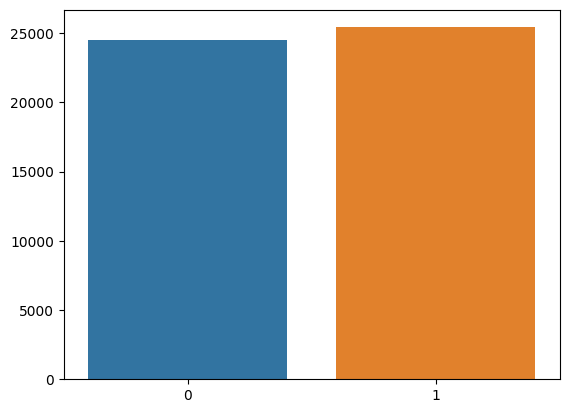

In [ ]:
import seaborn as sns
data_count = train_data['label'].value_counts()
sns.barplot(x=np.array([1,0]),y=data_count.values)
plt.show()

In [ ]:
# nltk.download('punkt')
# nltk.download('wordnet')
# from textaugment import EDA
# t = EDA()

# # Create a new dataframe for augmented data
# augmented_df = pd.DataFrame(columns=['text', 'label'])

# #Apply augmentation
# for index, row in tqdm(train_data.iterrows()):
#   augmented_df.loc[len(augmented_df)] = {'text': t.synonym_replacement( row['text']), 'label': row['label']}

# train_data = pd.concat([train_data, augmented_df]) 

In [ ]:
# augmented_df.info

In [ ]:
def split_long_doc(doc, seg_length):
  res = []
  ldoc = doc.split()
  while len(ldoc) > seg_length:
    res.append(' '.join(ldoc[:seg_length]))
    ldoc = ldoc[seg_length:]
  res.append(' '.join(ldoc))
  return res

In [ ]:
# Create a new dataframe for augmented data
segmented_df = pd.DataFrame(columns=['text', 'label'])

for index, row in tqdm(train_data.iterrows()):
  segs = split_long_doc(row['text'], 395)
  for s in segs:
    segmented_df.loc[len(segmented_df)] = {'text': s, 'label': row['label']}

segmented_df

49972it [03:12, 259.71it/s]


,text,label
0,white house flatly denying media reports trump...,0
1,geneva \( reuters \) venezuelan president nico...,0
2,"realize , second amendment applies white peopl...",1
3,stocks marched higher higher 5 percent preside...,0
4,", idea theoretical trump impeachment reason he...",0
...,...,...
68042,\( reuters \) family australian woman fatally ...,0
68043,tel aviv \( reuters \) thousands israelis prot...,0
68044,seoul \( reuters \) united nations nuclear wat...,0
68045,"difference , point , \? remember infamous wret...",1


In [ ]:
train_data = segmented_df

In [ ]:
train_data.info

<bound method DataFrame.info of                                                     text  label
0      white house flatly denying media reports trump...      0
1      geneva \( reuters \) venezuelan president nico...      0
2      realize , second amendment applies white peopl...      1
3      stocks marched higher higher 5 percent preside...      0
4      , idea theoretical trump impeachment reason he...      0
...                                                  ...    ...
68042  \( reuters \) family australian woman fatally ...      0
68043  tel aviv \( reuters \) thousands israelis prot...      0
68044  seoul \( reuters \) united nations nuclear wat...      0
68045  difference , point , \? remember infamous wret...      1
68046  21st century wire says living rock 20 years , ...      1

[68047 rows x 2 columns]>

In [ ]:
# Convert pyhton dataframe to Hugging Face arrow dataset
hg_train_data = Dataset.from_pandas(train_data)
hg_val_data = Dataset.from_pandas(val_data)
hg_test_data = Dataset.from_pandas(test_data)

In [ ]:
# Tokenizer from a pretrained model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Take a look at the tokenizer
tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [ ]:
# Mapping between special tokens and their IDs.
print(f'The unknown token is {tokenizer.unk_token} and the ID for the unkown token is {tokenizer.unk_token_id}.')
print(f'The seperator token is {tokenizer.sep_token} and the ID for the seperator token is {tokenizer.sep_token_id}.')
print(f'The pad token is {tokenizer.pad_token} and the ID for the pad token is {tokenizer.pad_token_id}.')
print(f'The sentence level classification token is {tokenizer.cls_token} and the ID for the classification token is {tokenizer.cls_token_id}.')
print(f'The mask token is {tokenizer.mask_token} and the ID for the mask token is {tokenizer.mask_token_id}.')


The unknown token is [UNK] and the ID for the unkown token is 100.
The seperator token is [SEP] and the ID for the seperator token is 102.
The pad token is [PAD] and the ID for the pad token is 0.
The sentence level classification token is [CLS] and the ID for the classification token is 101.
The mask token is [MASK] and the ID for the mask token is 103.


In [ ]:
# Funtion to tokenize data
def tokenize_dataset(data):
    return tokenizer(data['text'], max_length=400, truncation=True,padding="max_length")

# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_dataset)
dataset_test = hg_test_data.map(tokenize_dataset)
dataset_val = hg_val_data.map(tokenize_dataset)

Map:   0%|          | 0/68047 [00:00<?, ? examples/s]

Map:   0%|          | 0/14277 [00:00<?, ? examples/s]

Map:   0%|          | 0/7139 [00:00<?, ? examples/s]

In [ ]:
# Take a look at the data
print(dataset_train)
print(dataset_val)
print(dataset_test)

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 68047
})
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 7139
})
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 14277
})


In [ ]:
# Load model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./",          
    logging_dir='./logs',            
    logging_strategy='epoch',
    logging_steps=100,    
    num_train_epochs=10,              
    per_device_train_batch_size=24,  
    per_device_eval_batch_size=24,  
    learning_rate=5e-6,
    seed=42,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

In [ ]:
# Number of evaluation modules
print(f'There are {len(evaluate.list_evaluation_modules())} evaluation models in Hugging Face.\n')

# List all evaluation metrics
evaluate.list_evaluation_modules()

In [ ]:
# Function to compute the metric
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    # probabilities = tf.nn.softmax(logits)
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
import torch, gc
gc.collect()

torch.cuda.empty_cache()

In [ ]:
# Train the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_test,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.219800,0.117648,0.956503
2,0.121700,0.132901,0.960006
3,0.091300,0.085715,0.973384
4,0.067800,0.101269,0.975835
5,0.051400,0.117161,0.975065
6,0.038200,0.126591,0.975625
7,0.028100,0.138088,0.977376
8,0.022100,0.144644,0.976326
9,0.014600,0.145398,0.977866
10,0.012000,0.148913,0.977306


There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.word_embeddings.weight', 'distilbert.embeddings.position_embeddings.weight', 'distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias', 'distilbert.transformer.layer.0.attention.q_lin.weight', 'distilbert.transformer.layer.0.attention.q_lin.bias', 'distilbert.transformer.layer.0.attention.k_lin.weight', 'distilbert.transformer.layer.0.attention.k_lin.bias', 'distilbert.transformer.layer.0.attention.v_lin.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.0.attention.out_lin.weight', 'distilbert.transformer.layer.0.attention.out_lin.bias', 'distilbert.transformer.layer.0.sa_layer_norm.weight', 'distilbert.transformer.layer.0.sa_layer_norm.bias', 'distilbert.transformer.layer.0.ffn.lin1.weight', 'distilbert.transformer.layer.0.ffn.lin1.bias', 'distilbert.transformer.layer.0.ffn.lin2.weight', 'distilbert.transformer.layer.0.ffn.lin2.bias', 'dist

TrainOutput(global_step=28360, training_loss=0.06669953753817065, metrics={'train_runtime': 25829.1579, 'train_samples_per_second': 26.345, 'train_steps_per_second': 1.098, 'total_flos': 7.0421945908944e+16, 'train_loss': 0.06669953753817065, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

In [ ]:
from sklearn.metrics import confusion_matrix
def calculate_tpr_fpr(y_real, y_pred):
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    
    return tpr, fpr

def get_n_roc_coordinates(y_real, y_proba, n = 50):
    tpr_list = [0]
    fpr_list = [0]
    for i in range(n):
        threshold = i/n
        y_pred = y_proba[:, 1] > threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list


In [ ]:
def plot_roc_curve(tpr, fpr, scatter = True):
    plt.figure(figsize = (5, 5))
    if scatter:
        sns.scatterplot(x = fpr, y = tpr)
    sns.lineplot(x = fpr, y = tpr)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
# Calculates 10 coordinates of the ROC Curve
tpr, fpr = get_n_roc_coordinates(y_test, y_proba, resolution = 10)
# Plots the ROC curve
plot_roc_curve(tpr, fpr)

In [ ]:
# Save tokenizer
tokenizer.save_pretrained('./')

# Save model
trainer.save_model('./')